**Test** with LSTM Self-Attention model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 9.8 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (128/128), done.
remote:

---

In [3]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [4]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.models.ts_transformer import RelativeGlobalAttention
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-4-9aed3ac8f118>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [6]:
# setup model configurations
config = {
    # general information
    "experiment-name": "Experiment_section-1", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "Self-Attention LSTM",
    "sem-space": 'I3D embeddings',
    # model training configs
    "lr": 0.0001,
    "imu_alpha": 0.0001,
    "n_epochs": 20,
    "batch_size": 64,
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 400, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "seq_len": 10,  # skeleton seq. length
    "seen_split": 0.1,
    "unseen_split": 0.8
}

In [7]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [8]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2ReaderV2(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [9]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [10]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat.pkl'
video_data = read_I3D_pkl(I3D_data_path,feat_size="400")
video_classes, video_feat = video_data['activity'], video_data['features']

In [11]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

In [43]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, n_classes, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        self.lstm = nn.LSTM(input_size=self.d_model,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu  # _get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(2*self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        self.logist = nn.Linear(self.ft_size, self.n_classes)
        self.DenseL3 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Act(out)
        out, _ = self.lstm(out)
        # print(out[:, - 1, :self.d_model].shape)
        out_forward = out[:, - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = torch.squeeze(out_reduced)
        out = self.dropout(out)
        out = self.DenseL2(out)   
        # out = self.DenseL3(out)
        # out = self.logist(out1)     
        return out

In [29]:
model = IMUEncoder(in_ft=12, d_model=128, num_heads=2, ft_size=128, n_classes=18, max_len=1024, dropout=0.1)

In [30]:
input_tensor = torch.rand((32,52,12))

In [31]:
output_tensor = model(input_tensor)
output_tensor.shape

torch.Size([32, 128])


torch.Size([32, 128])

---

In [32]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [34]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [35]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [36]:
def loss_cross_entropy(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    pred = torch.argmax(softmax_vec, dim=-1)
    return output, pred

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    loss = loss_fn(y_pred,y_feat)
    return loss

def predict_class(y_pred, feat):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    pred = torch.argmax(softmax_vec, dim=-1)
    return pred

In [37]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [38]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])
            
            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [39]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [40]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [41]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

<ipython-input-41-0fd58e113600>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-177


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.269



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.508



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.697



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.773



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.894



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.884



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.899



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.943



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.943



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.900



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.934



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.958



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.968



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.980



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.978



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.974



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.968



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.989



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.979



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.981



unseen:   0%|          | 0/42 [00:00<?, ?batch/s]

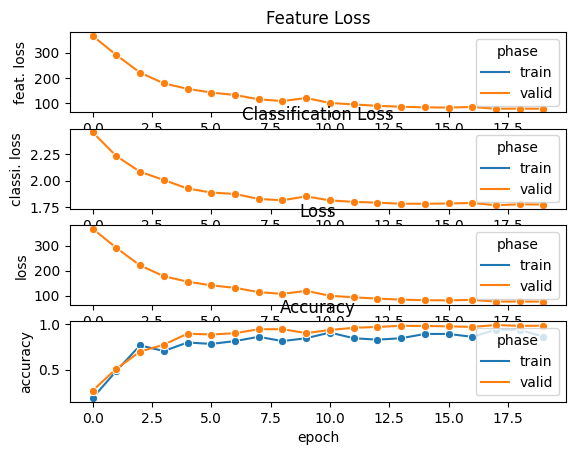

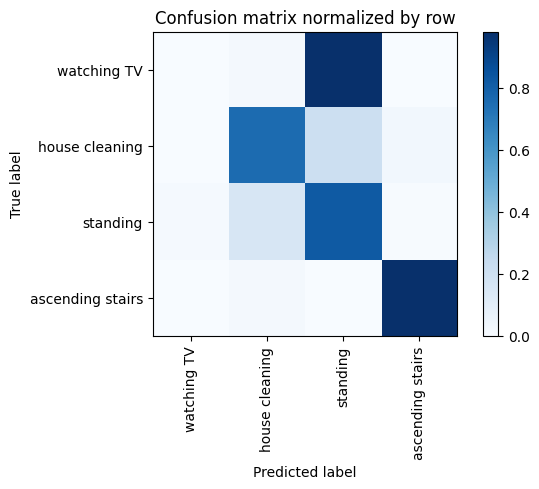

Overall accuracy: 0.702

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  house cleaning       0.811      0.758      0.783      0.335        900|	 standing: 0.212,	ascending stairs: 0.028,	
        standing       0.552      0.821      0.660      0.333        895|	 house cleaning: 0.159,	watching TV: 0.015,	
ascending stairs       0.940      0.977      0.958      0.179        481|	 house cleaning: 0.021,	standing: 0.002,	
     watching TV       0.062      0.002      0.005      0.153        412|	 standing: 0.981,	house cleaning: 0.017,	

----------------------------------------------------------------------------------------------------
     avg / total       0.633      0.702      0.654        1.0       2688|	      

{'accuracy': 0.7023809523809523, 'precision': 0.5914139341424782, 'recall': 0.639641247413526, 'f1': 0.6016784877261451, 'samples': 2688, 'loss': 1095064.78515625, 'feat. loss': 1095064.529296875, 'classi. loss': 2718.778095245361

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.355



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.597



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.746



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.762



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.890



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.891



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.907



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.885



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.928



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.911



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.947



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.944



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.939



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.941



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.947



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.955



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.971



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.965



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.965



unseen:   0%|          | 0/41 [00:00<?, ?batch/s]

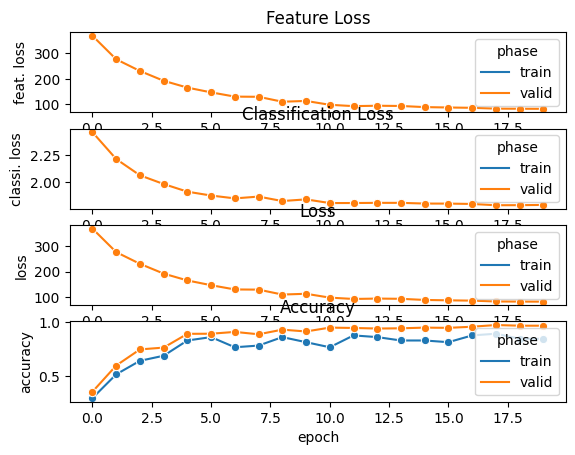

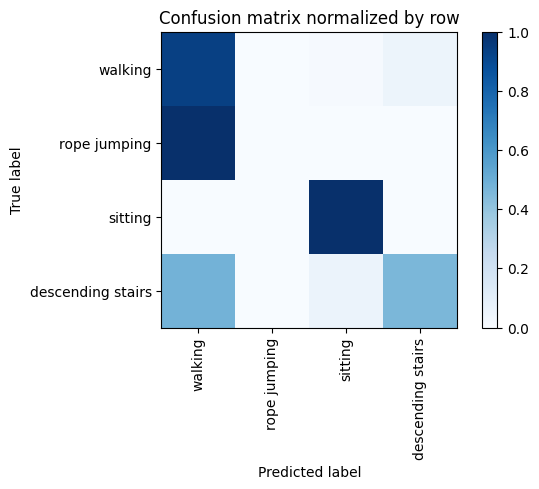

Overall accuracy: 0.808

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.722      0.937      0.815      0.431       1131|	 descending stairs: 0.051,	sitting: 0.011,	
          sitting       0.958      1.000      0.979      0.332        871|	 descending stairs: 0.000,	rope jumping: 0.000,	
descending stairs       0.764      0.460      0.574      0.156        409|	 walking: 0.479,	sitting: 0.061,	
     rope jumping       0.000      0.000      0.000      0.081        213|	 walking: 1.000,	descending stairs: 0.000,	sitting: 0.000,	

----------------------------------------------------------------------------------------------------
      avg / total       0.748      0.808      0.766        1.0       2624|	      

{'accuracy': 0.807545731707317, 'precision': 0.6110006918771208, 'recall': 0.5992203493889693, 'f1': 0.5920205255761479, 'samples': 2624, 'loss': 1051852.78125, 'feat. loss': 1051852.5390625, 'classi. loss': 24

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.203



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.252



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.498



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.597



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.782



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.788



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.804



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.806



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.797



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.837



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.894



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.930



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.940



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.920



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.943



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.941



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.942



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.952



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.927



unseen:   0%|          | 0/54 [00:00<?, ?batch/s]

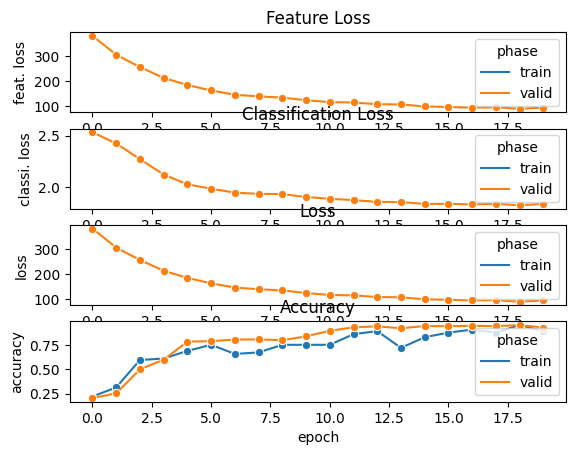

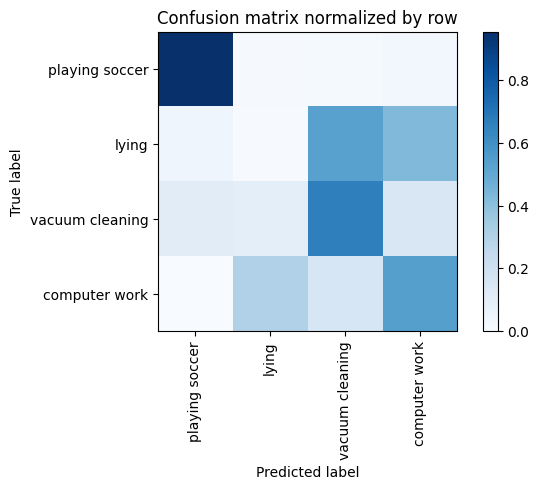

Overall accuracy: 0.455

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.617      0.540      0.576      0.437       1511|	 lying: 0.304,	vacuum cleaning: 0.156,	
          lying       0.011      0.007      0.008      0.263        908|	 vacuum cleaning: 0.531,	computer work: 0.425,	playing soccer: 0.037,	
vacuum cleaning       0.429      0.662      0.521      0.237        819|	 computer work: 0.142,	playing soccer: 0.106,	
 playing soccer       0.632      0.954      0.761      0.063        218|	 computer work: 0.023,	vacuum cleaning: 0.014,	

----------------------------------------------------------------------------------------------------
    avg / total       0.414      0.455      0.425        1.0       3456|	      

{'accuracy': 0.4548611111111111, 'precision': 0.4223066097011201, 'recall': 0.5406396851167927, 'f1': 0.4663277942566755, 'samples': 3456, 'loss': 1697476.2109375, 'feat. loss': 1697475.7890625, 'classi.

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.232



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.529



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.766



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.813



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.838



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.792



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.829



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.847



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.842



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.870



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.916



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.907



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.914



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.916



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.924



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.958



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.951



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.959



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.960



unseen:   0%|          | 0/33 [00:00<?, ?batch/s]

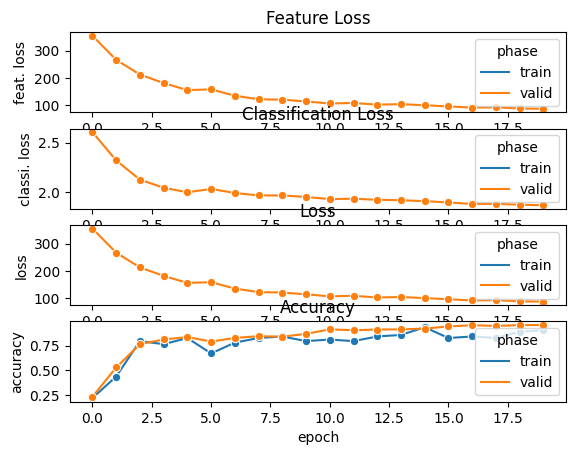

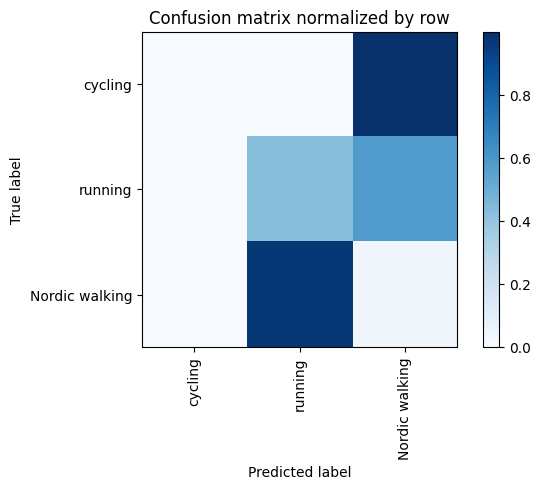

Overall accuracy: 0.104

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.026      0.031      0.029      0.421        890|	 running: 0.969,	cycling: 0.000,	
       cycling       1.000      0.001      0.003      0.366        773|	 Nordic walking: 0.999,	running: 0.000,	
       running       0.181      0.425      0.254      0.213        449|	 Nordic walking: 0.575,	cycling: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.416      0.104      0.067        1.0       2112|	      

{'accuracy': 0.10416666666666667, 'precision': 0.40261718102507854, 'recall': 0.15271469674308044, 'f1': 0.09521965861401792, 'samples': 2112, 'loss': 1332436.953125, 'feat. loss': 1332436.6953125, 'classi. loss': 2713.413528442383, 'N': 3}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.182



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.362



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.543



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.734



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.855



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.853



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.866



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.877



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.878



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.881



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.885



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.887



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.894



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.908



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.932



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.949



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.959



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.962



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.968



unseen:   0%|          | 0/29 [00:00<?, ?batch/s]

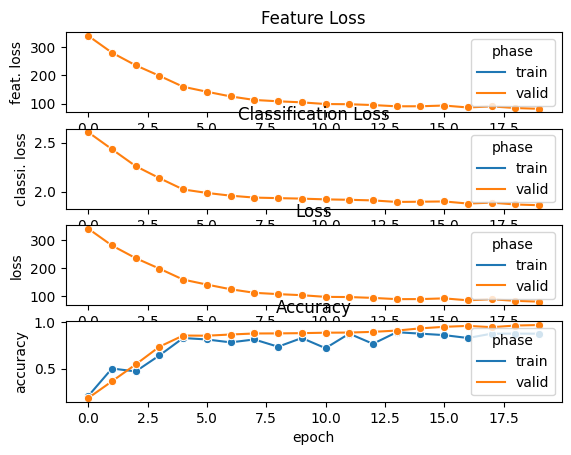

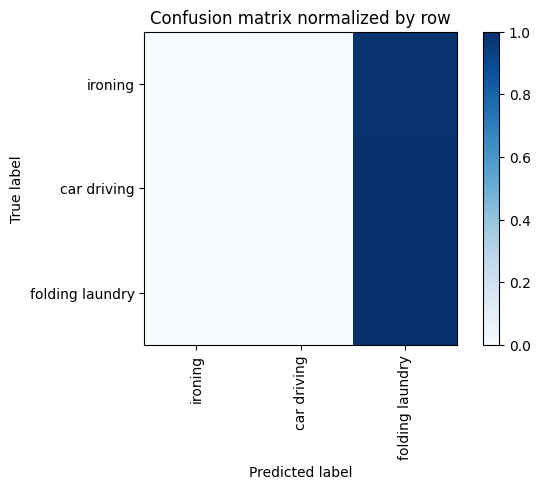

Overall accuracy: 0.251

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.000      0.000      0.000      0.608       1128|	 folding laundry: 0.987,	car driving: 0.013,	
folding laundry       0.253      1.000      0.404      0.251        466|	 car driving: 0.000,	ironing: 0.000,	
    car driving       0.000      0.000      0.000      0.141        262|	 folding laundry: 1.000,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.064      0.251      0.101        1.0       1856|	      

{'accuracy': 0.2510775862068966, 'precision': 0.08437443418432011, 'recall': 0.3333333333333333, 'f1': 0.13466262100852475, 'samples': 1856, 'loss': 1229169.921875, 'feat. loss': 1229169.6953125, 'classi. loss': 2383.336929321289, 'N': 3}
============== Overall Unseen Classes Performance ==============
accuracy     0.495827
precision    0.442214
recall  

In [44]:
run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=12, window_overlap=10, resample_freq=50)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-6)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'eval', eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=True, show_plot=True)
    test_metrics['N'] = len(unseen_classes)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
weighted_score_df = seen_score_df[["accuracy", "precision", "recall", "f1"]].multiply(seen_score_df["N"], axis="index")
final_results = weighted_score_df.sum()/seen_score_df['N'].sum()
print(final_results)
log('global', '',final_results.to_dict())
run.stop()
